In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Input,Dense, SimpleRNN, Embedding, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.models import Model

In [18]:
# preparing dataset

file1 = open("/content/POS_train.txt", "r")
X = [] # contains the words
Y = [] # contains corresponding tags
x = []
y = []
for i in file1:
  s = i.split(" ")
  if s[0]!='.':
    x.append(s[0])
    y.append(s[1][:-1])
  else:
    X.append(x)
    Y.append(y)
    x = []
    y = []
# print(X)
# print(Y)

In [19]:
unique_words = len(set([word.lower() for sentence in X for word in sentence]))
print(unique_words)

17258


In [20]:
# to find the different types of tags
total_tags   = len(set([word.lower() for sentence in Y for word in sentence]))
print(total_tags)

45


In [21]:
# code to vectorize X and Y

# encoding X
word_tokenizer = Tokenizer()              # instantiate tokeniser
word_tokenizer.fit_on_texts(X)            # fit tokeniser on data
# use the tokeniser to encode input sequence
X_encd = word_tokenizer.texts_to_sequences(X)  

# encoding Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encd = tag_tokenizer.texts_to_sequences(Y)

# look at first encoded data point

print('X: ', X_encd[0])
print('Y: ', Y_encd[0])

X:  [1536, 7, 2, 1637, 15, 1106, 184, 5, 207, 246, 1146, 4973, 71, 481, 566, 9, 461, 1, 252, 9, 1750, 2555, 1, 4171, 5, 598, 6, 1309, 1537, 21, 736, 8, 549, 10, 6326, 8935]
Y:  [1, 2, 4, 1, 16, 11, 15, 14, 12, 4, 6, 1, 2, 1, 5, 2, 3, 7, 6, 2, 1, 1, 7, 12, 14, 12, 4, 6, 1, 2, 3, 13, 3, 22, 6, 5]


In [22]:
# check length of longest sentence
longest = [len(seq) for seq in X_encd]
print("longest sentence: {}".format(max(longest)))

longest sentence: 130


In [23]:
# Pad Sequences

# we set a particular sentence length (max_length)
# sentences longer than max_length - truncated from the back
# sentences shorter than max_length - padded with zeros in front

max_length = 100

X_padded = pad_sequences(X_encd, maxlen= max_length, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encd, maxlen= max_length, padding="pre", truncating="post")
# print the first sequence
print(X_padded[0])
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 1536    7    2 1637   15 1106
  184    5  207  246 1146 4973   71  481  566    9  461    1  252    9
 1750 2555    1 4171    5  598    6 1309 1537   21  736    8  549   10
 6326 8935]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  4  1 16 11 15 14
 12  4  6  1  2  1  5  2  3  7  6  2  1  1  7 12 14 12  4  6  1  2  3 13
  3 22  6  5]


In [24]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [25]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)
Y.shape

(8725, 100, 46)

In [26]:
# split entire data into training and testing sets
ts = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ts, random_state=4)

In [27]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_train.shape

(7416, 100)

In [28]:
Y_train.shape

(7416, 100, 46)

In [29]:
# total number of tags
NUM_CLASSES = Y.shape[2]
NUM_CLASSES

46

In [30]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim = 17259, 
                           output_dim = 100,
                           input_length = 130,
                           trainable = False
))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bilstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
bilstm_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
# check summary of model
bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 100)          1725900   
_________________________________________________________________
bidirectional (Bidirectional (None, 130, 128)          84480     
_________________________________________________________________
time_distributed (TimeDistri (None, 130, 46)           5934      
Total params: 1,816,314
Trainable params: 90,414
Non-trainable params: 1,725,900
_________________________________________________________________


In [36]:
bilstm_training = bilstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
58/58 [==============================] - 17s 301ms/step - loss: 0.6017 - acc: 0.8388 - val_loss: 0.5820 - val_acc: 0.8428
Epoch 2/10
58/58 [==============================] - 17s 300ms/step - loss: 0.5756 - acc: 0.8464 - val_loss: 0.5570 - val_acc: 0.8520
Epoch 3/10
58/58 [==============================] - 17s 300ms/step - loss: 0.5505 - acc: 0.8551 - val_loss: 0.5331 - val_acc: 0.8582
Epoch 4/10
58/58 [==============================] - 17s 299ms/step - loss: 0.5272 - acc: 0.8595 - val_loss: 0.5113 - val_acc: 0.8616
Epoch 5/10
58/58 [==============================] - 17s 301ms/step - loss: 0.5066 - acc: 0.8621 - val_loss: 0.4921 - val_acc: 0.8636
Epoch 6/10
58/58 [==============================] - 18s 302ms/step - loss: 0.4886 - acc: 0.8641 - val_loss: 0.4757 - val_acc: 0.8654
Epoch 7/10
58/58 [==============================] - 17s 298ms/step - loss: 0.4727 - acc: 0.8663 - val_loss: 0.4602 - val_acc: 0.8674
Epoch 8/10
58/58 [==============================] - 17s 297ms/step - 

In [43]:
bilstm_model.save('bilstm_model.bin')

INFO:tensorflow:Assets written to: bilstm_model.bin/assets


INFO:tensorflow:Assets written to: bilstm_model.bin/assets


In [44]:
bilstm_model.save_weights("BiLSTM_pos_tagging_model")

In [37]:
bilstm_training.history['acc']

[0.8388322591781616,
 0.8463821411132812,
 0.8551051616668701,
 0.8595321178436279,
 0.8620576858520508,
 0.8641113638877869,
 0.8662985563278198,
 0.8694902658462524,
 0.8736246228218079,
 0.8778815865516663]

In [38]:
bilstm_training.history['val_acc']

[0.8428418636322021,
 0.8519633412361145,
 0.858166515827179,
 0.8616424798965454,
 0.8635981678962708,
 0.8653781414031982,
 0.8674026131629944,
 0.8723605871200562,
 0.8769212961196899,
 0.8816577792167664]

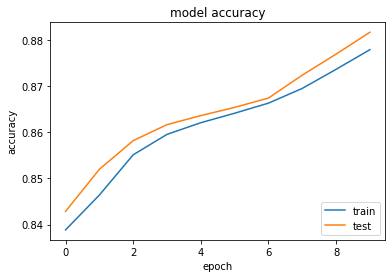

In [39]:
# visualise training history
plt.plot(bilstm_training.history['acc'])
plt.plot(bilstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [42]:
loss, accuracy = bilstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: ",loss)
print("Accuracy: ", accuracy)

41/41 [==============================] - 1s 31ms/step - loss: 0.4198 - acc: 0.8817
Loss:  0.4197750389575958
Accuracy:  0.8816577792167664
